<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[11:00:51] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


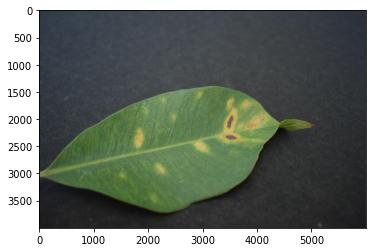

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

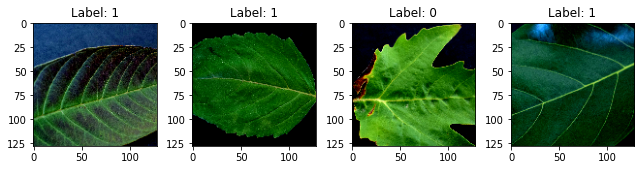

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[11:00:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[11:01:00] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2538514686808349 samples/sec                   batch loss = 1.2859711647033691 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.262786023712102 samples/sec                   batch loss = 0.6539556980133057 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.263835075751538 samples/sec                   batch loss = 0.6254579424858093 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.260475099156799 samples/sec                   batch loss = 0.7734660506248474 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.259008583090645 samples/sec                   batch loss = 1.641088604927063 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.26043939837764 samples/sec                   batch loss = 0.6910618543624878 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2625635572573142 samples/sec                   batch loss = 0.7655242681503296 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2558831382735958 samples/sec                   batch loss = 0.7882523536682129 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2601959862331915 samples/sec                   batch loss = 0.37498384714126587 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2566337001495027 samples/sec                   batch loss = 0.5316452383995056 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2609526612583013 samples/sec                   batch loss = 2.2627015113830566 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2631249581680415 samples/sec                   batch loss = 0.967562198638916 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.260399628007722 samples/sec                   batch loss = 0.8101010918617249 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2599759453359072 samples/sec                   batch loss = 1.458014965057373 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.2600137963613505 samples/sec                   batch loss = 0.6822326183319092 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2607644731861611 samples/sec                   batch loss = 1.5907232761383057 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.2635153622044546 samples/sec                   batch loss = 0.3151623606681824 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2658042227385367 samples/sec                   batch loss = 0.5398257374763489 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.2638758249137552 samples/sec                   batch loss = 0.5259987115859985 | accuracy = 0.5973684210526315


Epoch[1] Batch[100] Speed: 1.2564197941271424 samples/sec                   batch loss = 0.5527155995368958 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.2623972100455336 samples/sec                   batch loss = 0.37507712841033936 | accuracy = 0.5928571428571429


Epoch[1] Batch[110] Speed: 1.2573687628413606 samples/sec                   batch loss = 1.429040789604187 | accuracy = 0.5954545454545455


Epoch[1] Batch[115] Speed: 1.254916697627163 samples/sec                   batch loss = 0.5096129775047302 | accuracy = 0.5891304347826087


Epoch[1] Batch[120] Speed: 1.2584167585320825 samples/sec                   batch loss = 0.48031675815582275 | accuracy = 0.5958333333333333


Epoch[1] Batch[125] Speed: 1.2585753548507415 samples/sec                   batch loss = 0.5757192969322205 | accuracy = 0.598


Epoch[1] Batch[130] Speed: 1.2599845562443646 samples/sec                   batch loss = 0.6871836185455322 | accuracy = 0.5980769230769231


Epoch[1] Batch[135] Speed: 1.2599415974985633 samples/sec                   batch loss = 0.3506157398223877 | accuracy = 0.6018518518518519


Epoch[1] Batch[140] Speed: 1.2575147475191444 samples/sec                   batch loss = 0.5645812749862671 | accuracy = 0.6


Epoch[1] Batch[145] Speed: 1.2614228082637957 samples/sec                   batch loss = 0.7190723419189453 | accuracy = 0.596551724137931


Epoch[1] Batch[150] Speed: 1.2666658563089257 samples/sec                   batch loss = 0.5061843991279602 | accuracy = 0.6


Epoch[1] Batch[155] Speed: 1.2657752862462237 samples/sec                   batch loss = 0.6229014992713928 | accuracy = 0.6016129032258064


Epoch[1] Batch[160] Speed: 1.2670751031217589 samples/sec                   batch loss = 0.6160893440246582 | accuracy = 0.6


Epoch[1] Batch[165] Speed: 1.272346525792461 samples/sec                   batch loss = 0.40682709217071533 | accuracy = 0.6045454545454545


Epoch[1] Batch[170] Speed: 1.2668322782322627 samples/sec                   batch loss = 1.1656019687652588 | accuracy = 0.6014705882352941


Epoch[1] Batch[175] Speed: 1.2650601255874778 samples/sec                   batch loss = 0.6077591180801392 | accuracy = 0.6


Epoch[1] Batch[180] Speed: 1.2631608112434245 samples/sec                   batch loss = 1.0022027492523193 | accuracy = 0.5986111111111111


Epoch[1] Batch[185] Speed: 1.2625385691273296 samples/sec                   batch loss = 0.42197391390800476 | accuracy = 0.6013513513513513


Epoch[1] Batch[190] Speed: 1.2612066051885538 samples/sec                   batch loss = 0.5923470854759216 | accuracy = 0.6039473684210527


Epoch[1] Batch[195] Speed: 1.2621695630791907 samples/sec                   batch loss = 0.754375159740448 | accuracy = 0.6051282051282051


Epoch[1] Batch[200] Speed: 1.2588813320964536 samples/sec                   batch loss = 0.48429417610168457 | accuracy = 0.6075


Epoch[1] Batch[205] Speed: 1.2624810906817272 samples/sec                   batch loss = 0.6592239141464233 | accuracy = 0.6073170731707317


Epoch[1] Batch[210] Speed: 1.2634356255944046 samples/sec                   batch loss = 0.6837846040725708 | accuracy = 0.6059523809523809


Epoch[1] Batch[215] Speed: 1.2536476889600918 samples/sec                   batch loss = 0.8141607642173767 | accuracy = 0.6046511627906976


Epoch[1] Batch[220] Speed: 1.2551061485045936 samples/sec                   batch loss = 0.6885141730308533 | accuracy = 0.6056818181818182


Epoch[1] Batch[225] Speed: 1.2549084374433168 samples/sec                   batch loss = 0.629105269908905 | accuracy = 0.6044444444444445


Epoch[1] Batch[230] Speed: 1.2580529876667852 samples/sec                   batch loss = 0.640367329120636 | accuracy = 0.6086956521739131


Epoch[1] Batch[235] Speed: 1.2590614938219202 samples/sec                   batch loss = 0.6258863210678101 | accuracy = 0.6095744680851064


Epoch[1] Batch[240] Speed: 1.2542931718719874 samples/sec                   batch loss = 0.5852170586585999 | accuracy = 0.6083333333333333


Epoch[1] Batch[245] Speed: 1.2541032163666848 samples/sec                   batch loss = 1.114837646484375 | accuracy = 0.6081632653061224


Epoch[1] Batch[250] Speed: 1.2589569049374083 samples/sec                   batch loss = 0.6237704157829285 | accuracy = 0.611


Epoch[1] Batch[255] Speed: 1.2554514942651218 samples/sec                   batch loss = 0.33052241802215576 | accuracy = 0.615686274509804


Epoch[1] Batch[260] Speed: 1.2580572328061288 samples/sec                   batch loss = 0.6310281753540039 | accuracy = 0.6153846153846154


Epoch[1] Batch[265] Speed: 1.2508037635907694 samples/sec                   batch loss = 0.4919484555721283 | accuracy = 0.6179245283018868


Epoch[1] Batch[270] Speed: 1.2561983421570078 samples/sec                   batch loss = 0.7645649909973145 | accuracy = 0.6212962962962963


Epoch[1] Batch[275] Speed: 1.2561711599333805 samples/sec                   batch loss = 0.605860710144043 | accuracy = 0.6218181818181818


Epoch[1] Batch[280] Speed: 1.252566470204577 samples/sec                   batch loss = 0.9782374501228333 | accuracy = 0.6223214285714286


Epoch[1] Batch[285] Speed: 1.2553881776086888 samples/sec                   batch loss = 0.26786988973617554 | accuracy = 0.6236842105263158


Epoch[1] Batch[290] Speed: 1.2553595275114144 samples/sec                   batch loss = 0.45967650413513184 | accuracy = 0.6267241379310344


Epoch[1] Batch[295] Speed: 1.2570273532733351 samples/sec                   batch loss = 0.3893992006778717 | accuracy = 0.6279661016949153


Epoch[1] Batch[300] Speed: 1.2589364049075151 samples/sec                   batch loss = 0.4396818280220032 | accuracy = 0.6308333333333334


Epoch[1] Batch[305] Speed: 1.2537987138284812 samples/sec                   batch loss = 0.5849401950836182 | accuracy = 0.6286885245901639


Epoch[1] Batch[310] Speed: 1.2534570860654528 samples/sec                   batch loss = 0.7072550654411316 | accuracy = 0.6290322580645161


Epoch[1] Batch[315] Speed: 1.2567873282829767 samples/sec                   batch loss = 0.6119523048400879 | accuracy = 0.6293650793650793


Epoch[1] Batch[320] Speed: 1.256712580492015 samples/sec                   batch loss = 0.3760887384414673 | accuracy = 0.6296875


Epoch[1] Batch[325] Speed: 1.2536245512672937 samples/sec                   batch loss = 0.41880056262016296 | accuracy = 0.6307692307692307


Epoch[1] Batch[330] Speed: 1.2626410932643777 samples/sec                   batch loss = 0.4890801012516022 | accuracy = 0.6310606060606061


Epoch[1] Batch[335] Speed: 1.2524078887020333 samples/sec                   batch loss = 0.6339665651321411 | accuracy = 0.6305970149253731


Epoch[1] Batch[340] Speed: 1.2582366868955404 samples/sec                   batch loss = 0.8069874048233032 | accuracy = 0.6316176470588235


Epoch[1] Batch[345] Speed: 1.258813418746767 samples/sec                   batch loss = 0.3565182685852051 | accuracy = 0.6340579710144928


Epoch[1] Batch[350] Speed: 1.25326083034763 samples/sec                   batch loss = 0.40761473774909973 | accuracy = 0.635


Epoch[1] Batch[355] Speed: 1.2561266739186703 samples/sec                   batch loss = 1.0466558933258057 | accuracy = 0.6373239436619719


Epoch[1] Batch[360] Speed: 1.2654651854093448 samples/sec                   batch loss = 0.7269785404205322 | accuracy = 0.6395833333333333


Epoch[1] Batch[365] Speed: 1.2694847548776582 samples/sec                   batch loss = 0.5877195596694946 | accuracy = 0.6404109589041096


Epoch[1] Batch[370] Speed: 1.2718448692177933 samples/sec                   batch loss = 0.4245399832725525 | accuracy = 0.6412162162162162


Epoch[1] Batch[375] Speed: 1.2656040818657346 samples/sec                   batch loss = 0.48565733432769775 | accuracy = 0.6406666666666667


Epoch[1] Batch[380] Speed: 1.261907448174233 samples/sec                   batch loss = 0.5969524383544922 | accuracy = 0.6421052631578947


Epoch[1] Batch[385] Speed: 1.2713491958063976 samples/sec                   batch loss = 0.8182863593101501 | accuracy = 0.6428571428571429


Epoch[1] Batch[390] Speed: 1.2617333030808022 samples/sec                   batch loss = 0.7538878917694092 | accuracy = 0.6435897435897436


Epoch[1] Batch[395] Speed: 1.2656399803408516 samples/sec                   batch loss = 0.7293965220451355 | accuracy = 0.6417721518987342


Epoch[1] Batch[400] Speed: 1.269510306910778 samples/sec                   batch loss = 0.746420681476593 | accuracy = 0.64


Epoch[1] Batch[405] Speed: 1.2674061952452746 samples/sec                   batch loss = 0.4787527322769165 | accuracy = 0.641358024691358


Epoch[1] Batch[410] Speed: 1.2639030559587625 samples/sec                   batch loss = 0.8544391989707947 | accuracy = 0.6414634146341464


Epoch[1] Batch[415] Speed: 1.2595273946496637 samples/sec                   batch loss = 0.6094826459884644 | accuracy = 0.6409638554216868


Epoch[1] Batch[420] Speed: 1.2617509526559565 samples/sec                   batch loss = 0.4243180751800537 | accuracy = 0.6428571428571429


Epoch[1] Batch[425] Speed: 1.2602070612901028 samples/sec                   batch loss = 0.2824206054210663 | accuracy = 0.6447058823529411


Epoch[1] Batch[430] Speed: 1.2609889597805546 samples/sec                   batch loss = 0.3547826111316681 | accuracy = 0.6465116279069767


Epoch[1] Batch[435] Speed: 1.256175110218082 samples/sec                   batch loss = 0.48225075006484985 | accuracy = 0.6488505747126436


Epoch[1] Batch[440] Speed: 1.2542578204140036 samples/sec                   batch loss = 0.7036011219024658 | accuracy = 0.6482954545454546


Epoch[1] Batch[445] Speed: 1.2507938789498805 samples/sec                   batch loss = 0.3893624544143677 | accuracy = 0.648876404494382


Epoch[1] Batch[450] Speed: 1.2573420010898273 samples/sec                   batch loss = 0.34053751826286316 | accuracy = 0.6477777777777778


Epoch[1] Batch[455] Speed: 1.252934092348052 samples/sec                   batch loss = 0.7306843400001526 | accuracy = 0.6478021978021978


Epoch[1] Batch[460] Speed: 1.2590951322419364 samples/sec                   batch loss = 0.33515575528144836 | accuracy = 0.6494565217391305


Epoch[1] Batch[465] Speed: 1.2581662955410102 samples/sec                   batch loss = 0.38867104053497314 | accuracy = 0.6516129032258065


Epoch[1] Batch[470] Speed: 1.2537693866742552 samples/sec                   batch loss = 0.5998376607894897 | accuracy = 0.6531914893617021


Epoch[1] Batch[475] Speed: 1.2591558938311913 samples/sec                   batch loss = 0.329243004322052 | accuracy = 0.6547368421052632


Epoch[1] Batch[480] Speed: 1.2562525220009837 samples/sec                   batch loss = 0.2854399085044861 | accuracy = 0.6557291666666667


Epoch[1] Batch[485] Speed: 1.259079257707399 samples/sec                   batch loss = 0.7836641073226929 | accuracy = 0.6556701030927835


Epoch[1] Batch[490] Speed: 1.253986046454962 samples/sec                   batch loss = 0.630840003490448 | accuracy = 0.6566326530612245


Epoch[1] Batch[495] Speed: 1.259099100938117 samples/sec                   batch loss = 1.4548389911651611 | accuracy = 0.658080808080808


Epoch[1] Batch[500] Speed: 1.2539485567071258 samples/sec                   batch loss = 0.5320553183555603 | accuracy = 0.6575


Epoch[1] Batch[505] Speed: 1.2520404817976614 samples/sec                   batch loss = 0.24876339733600616 | accuracy = 0.6589108910891089


Epoch[1] Batch[510] Speed: 1.2591893482823961 samples/sec                   batch loss = 0.4895108938217163 | accuracy = 0.6588235294117647


Epoch[1] Batch[515] Speed: 1.2567769722649667 samples/sec                   batch loss = 0.9885838627815247 | accuracy = 0.6592233009708738


Epoch[1] Batch[520] Speed: 1.2513240466897397 samples/sec                   batch loss = 0.3505345284938812 | accuracy = 0.6591346153846154


Epoch[1] Batch[525] Speed: 1.251451734693261 samples/sec                   batch loss = 0.4745675325393677 | accuracy = 0.6604761904761904


Epoch[1] Batch[530] Speed: 1.2538232634917104 samples/sec                   batch loss = 0.5437961220741272 | accuracy = 0.660377358490566


Epoch[1] Batch[535] Speed: 1.2530802657150242 samples/sec                   batch loss = 0.22628174722194672 | accuracy = 0.6616822429906543


Epoch[1] Batch[540] Speed: 1.2557383780577869 samples/sec                   batch loss = 0.5189369320869446 | accuracy = 0.6611111111111111


Epoch[1] Batch[545] Speed: 1.2617439307228246 samples/sec                   batch loss = 0.39899176359176636 | accuracy = 0.6619266055045872


Epoch[1] Batch[550] Speed: 1.2497887000055572 samples/sec                   batch loss = 0.49078792333602905 | accuracy = 0.6627272727272727


Epoch[1] Batch[555] Speed: 1.260616501683593 samples/sec                   batch loss = 0.23941999673843384 | accuracy = 0.6644144144144144


Epoch[1] Batch[560] Speed: 1.2617527555973436 samples/sec                   batch loss = 0.40027710795402527 | accuracy = 0.6651785714285714


Epoch[1] Batch[565] Speed: 1.2698554561755264 samples/sec                   batch loss = 0.45125919580459595 | accuracy = 0.6654867256637168


Epoch[1] Batch[570] Speed: 1.2692103755118251 samples/sec                   batch loss = 0.9293917417526245 | accuracy = 0.6653508771929825


Epoch[1] Batch[575] Speed: 1.2676206024191696 samples/sec                   batch loss = 0.4734596312046051 | accuracy = 0.6660869565217391


Epoch[1] Batch[580] Speed: 1.269856801779245 samples/sec                   batch loss = 0.4781981408596039 | accuracy = 0.6685344827586207


Epoch[1] Batch[585] Speed: 1.2627960988028692 samples/sec                   batch loss = 0.695734977722168 | accuracy = 0.6679487179487179


Epoch[1] Batch[590] Speed: 1.2657860775886622 samples/sec                   batch loss = 0.23580189049243927 | accuracy = 0.6690677966101695


Epoch[1] Batch[595] Speed: 1.2673840787576487 samples/sec                   batch loss = 0.656261146068573 | accuracy = 0.6701680672268907


Epoch[1] Batch[600] Speed: 1.2729476648232418 samples/sec                   batch loss = 0.9954906105995178 | accuracy = 0.6708333333333333


Epoch[1] Batch[605] Speed: 1.2684267862098977 samples/sec                   batch loss = 0.39958617091178894 | accuracy = 0.6727272727272727


Epoch[1] Batch[610] Speed: 1.2716083087546797 samples/sec                   batch loss = 0.5597177147865295 | accuracy = 0.6729508196721311


Epoch[1] Batch[615] Speed: 1.2672022932463376 samples/sec                   batch loss = 0.7356698513031006 | accuracy = 0.6723577235772358


Epoch[1] Batch[620] Speed: 1.2667364368190397 samples/sec                   batch loss = 0.45415198802948 | accuracy = 0.6733870967741935


Epoch[1] Batch[625] Speed: 1.2653453103031436 samples/sec                   batch loss = 0.9499990344047546 | accuracy = 0.6744


Epoch[1] Batch[630] Speed: 1.2673376462193606 samples/sec                   batch loss = 0.25173819065093994 | accuracy = 0.675


Epoch[1] Batch[635] Speed: 1.266286692462042 samples/sec                   batch loss = 0.4191865921020508 | accuracy = 0.6755905511811023


Epoch[1] Batch[640] Speed: 1.2561219715642564 samples/sec                   batch loss = 0.41672128438949585 | accuracy = 0.67734375


Epoch[1] Batch[645] Speed: 1.2645706786188176 samples/sec                   batch loss = 0.6319194436073303 | accuracy = 0.6779069767441861


Epoch[1] Batch[650] Speed: 1.266489248228244 samples/sec                   batch loss = 1.2625669240951538 | accuracy = 0.6776923076923077


Epoch[1] Batch[655] Speed: 1.2643988470205616 samples/sec                   batch loss = 0.4714427590370178 | accuracy = 0.6782442748091603


Epoch[1] Batch[660] Speed: 1.2570924366524083 samples/sec                   batch loss = 0.6568201184272766 | accuracy = 0.678030303030303


Epoch[1] Batch[665] Speed: 1.2561810356917191 samples/sec                   batch loss = 1.3764740228652954 | accuracy = 0.6785714285714286


Epoch[1] Batch[670] Speed: 1.2529028407527745 samples/sec                   batch loss = 0.37902289628982544 | accuracy = 0.6783582089552239


Epoch[1] Batch[675] Speed: 1.250223445594407 samples/sec                   batch loss = 0.6879048347473145 | accuracy = 0.6796296296296296


Epoch[1] Batch[680] Speed: 1.2605458438098844 samples/sec                   batch loss = 0.421445369720459 | accuracy = 0.680514705882353


Epoch[1] Batch[685] Speed: 1.2559200856742514 samples/sec                   batch loss = 0.4984021782875061 | accuracy = 0.6810218978102189


Epoch[1] Batch[690] Speed: 1.2546213697623765 samples/sec                   batch loss = 0.3054965138435364 | accuracy = 0.6811594202898551


Epoch[1] Batch[695] Speed: 1.2581281780413303 samples/sec                   batch loss = 0.07439680397510529 | accuracy = 0.6820143884892086


Epoch[1] Batch[700] Speed: 1.2524616485682802 samples/sec                   batch loss = 0.406297504901886 | accuracy = 0.6825


Epoch[1] Batch[705] Speed: 1.2568164201921361 samples/sec                   batch loss = 0.6786113977432251 | accuracy = 0.6812056737588652


Epoch[1] Batch[710] Speed: 1.259971781861942 samples/sec                   batch loss = 0.31066036224365234 | accuracy = 0.6834507042253521


Epoch[1] Batch[715] Speed: 1.252388723257008 samples/sec                   batch loss = 0.6888324618339539 | accuracy = 0.6839160839160839


Epoch[1] Batch[720] Speed: 1.2521048628986335 samples/sec                   batch loss = 0.5820749998092651 | accuracy = 0.6840277777777778


Epoch[1] Batch[725] Speed: 1.2544766188592882 samples/sec                   batch loss = 0.5971311330795288 | accuracy = 0.6841379310344827


Epoch[1] Batch[730] Speed: 1.2555258102385138 samples/sec                   batch loss = 0.7866141200065613 | accuracy = 0.6839041095890411


Epoch[1] Batch[735] Speed: 1.2576112724655415 samples/sec                   batch loss = 0.1850021928548813 | accuracy = 0.6843537414965987


Epoch[1] Batch[740] Speed: 1.2555991953252228 samples/sec                   batch loss = 1.007058024406433 | accuracy = 0.6851351351351351


Epoch[1] Batch[745] Speed: 1.2534556813452902 samples/sec                   batch loss = 0.5183386206626892 | accuracy = 0.6862416107382551


Epoch[1] Batch[750] Speed: 1.2648854907733231 samples/sec                   batch loss = 0.4946838617324829 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.2580234611568792 samples/sec                   batch loss = 1.8716386556625366 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2539909202868333 samples/sec                   batch loss = 0.35752031207084656 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.258629645511678 samples/sec                   batch loss = 0.24791598320007324 | accuracy = 0.6892156862745098


Epoch[1] Batch[770] Speed: 1.2555955305655406 samples/sec                   batch loss = 0.7159093618392944 | accuracy = 0.6905844155844156


Epoch[1] Batch[775] Speed: 1.2543842321513299 samples/sec                   batch loss = 0.14696739614009857 | accuracy = 0.6906451612903226


Epoch[1] Batch[780] Speed: 1.258764778778896 samples/sec                   batch loss = 0.9138123989105225 | accuracy = 0.6907051282051282


Epoch[1] Batch[785] Speed: 1.259221859395733 samples/sec                   batch loss = 0.8815100789070129 | accuracy = 0.6910828025477707


[Epoch 1] training: accuracy=0.6913071065989848
[Epoch 1] time cost: 652.8165884017944
[Epoch 1] validation: validation accuracy=0.7533333333333333


Epoch[2] Batch[5] Speed: 1.2620208818626908 samples/sec                   batch loss = 0.23403336107730865 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2612043297608817 samples/sec                   batch loss = 0.7196463346481323 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2596607346422213 samples/sec                   batch loss = 0.6312084794044495 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.2688806434095745 samples/sec                   batch loss = 0.7621453404426575 | accuracy = 0.6625


Epoch[2] Batch[25] Speed: 1.268694782674255 samples/sec                   batch loss = 0.4254196584224701 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2699808979225402 samples/sec                   batch loss = 0.785119891166687 | accuracy = 0.7


Epoch[2] Batch[35] Speed: 1.2762645464481057 samples/sec                   batch loss = 0.2718435525894165 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2742198722120581 samples/sec                   batch loss = 0.46520304679870605 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2705094672069728 samples/sec                   batch loss = 0.6538735032081604 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.275200970590491 samples/sec                   batch loss = 0.9366927146911621 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2671637219858798 samples/sec                   batch loss = 0.989814817905426 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2706138674089051 samples/sec                   batch loss = 0.1532619297504425 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2679501590226487 samples/sec                   batch loss = 0.23057496547698975 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2706584231329714 samples/sec                   batch loss = 0.29264336824417114 | accuracy = 0.7571428571428571


Epoch[2] Batch[75] Speed: 1.265213054097663 samples/sec                   batch loss = 0.21149981021881104 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2689574216073203 samples/sec                   batch loss = 0.7203570604324341 | accuracy = 0.76875


Epoch[2] Batch[85] Speed: 1.2721135404912387 samples/sec                   batch loss = 0.4456539750099182 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.269094589787116 samples/sec                   batch loss = 0.5458710789680481 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2665139149413653 samples/sec                   batch loss = 0.7607342600822449 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2638637331825686 samples/sec                   batch loss = 0.38164806365966797 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.266022196191599 samples/sec                   batch loss = 0.5846849083900452 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2749236305728175 samples/sec                   batch loss = 0.6120608448982239 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2631792616297657 samples/sec                   batch loss = 0.49888479709625244 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.261853728539098 samples/sec                   batch loss = 0.3667009472846985 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.2600149319272498 samples/sec                   batch loss = 0.44129252433776855 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.2594611134282636 samples/sec                   batch loss = 0.2187620997428894 | accuracy = 0.75


Epoch[2] Batch[135] Speed: 1.2654132621929375 samples/sec                   batch loss = 0.998493492603302 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2629686359173358 samples/sec                   batch loss = 0.3561800718307495 | accuracy = 0.7428571428571429


Epoch[2] Batch[145] Speed: 1.2673843659798136 samples/sec                   batch loss = 1.503110408782959 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.268304335901509 samples/sec                   batch loss = 0.48422542214393616 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2574002376266238 samples/sec                   batch loss = 0.5859068632125854 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2620002819286023 samples/sec                   batch loss = 0.5060590505599976 | accuracy = 0.7375


Epoch[2] Batch[165] Speed: 1.2570272590909841 samples/sec                   batch loss = 0.6574398279190063 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2584979397490523 samples/sec                   batch loss = 0.30806460976600647 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2596785154410182 samples/sec                   batch loss = 0.5936190485954285 | accuracy = 0.7371428571428571


Epoch[2] Batch[180] Speed: 1.2643496791839717 samples/sec                   batch loss = 0.5582273602485657 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2575255869845041 samples/sec                   batch loss = 0.2918963134288788 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2645142539982013 samples/sec                   batch loss = 0.49793902039527893 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.2692734617000132 samples/sec                   batch loss = 2.0018930435180664 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.2710608171701385 samples/sec                   batch loss = 0.5320039391517639 | accuracy = 0.73375


Epoch[2] Batch[205] Speed: 1.2663837084931986 samples/sec                   batch loss = 0.531144380569458 | accuracy = 0.7353658536585366


Epoch[2] Batch[210] Speed: 1.272237016896261 samples/sec                   batch loss = 0.4381178617477417 | accuracy = 0.7392857142857143


Epoch[2] Batch[215] Speed: 1.272177687350719 samples/sec                   batch loss = 0.2557429373264313 | accuracy = 0.7418604651162791


Epoch[2] Batch[220] Speed: 1.2719391709007233 samples/sec                   batch loss = 0.728338360786438 | accuracy = 0.7420454545454546


Epoch[2] Batch[225] Speed: 1.2719464996334398 samples/sec                   batch loss = 0.7503824234008789 | accuracy = 0.7422222222222222


Epoch[2] Batch[230] Speed: 1.2715372806793166 samples/sec                   batch loss = 1.038771629333496 | accuracy = 0.7391304347826086


Epoch[2] Batch[235] Speed: 1.2700806922740162 samples/sec                   batch loss = 0.36024749279022217 | accuracy = 0.7382978723404255


Epoch[2] Batch[240] Speed: 1.268607196570714 samples/sec                   batch loss = 0.529639720916748 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2715728419124173 samples/sec                   batch loss = 0.5781040787696838 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2767089717081372 samples/sec                   batch loss = 0.644260823726654 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2722433842982452 samples/sec                   batch loss = 0.8762186169624329 | accuracy = 0.7352941176470589


Epoch[2] Batch[260] Speed: 1.2785396562809614 samples/sec                   batch loss = 0.9208687543869019 | accuracy = 0.7346153846153847


Epoch[2] Batch[265] Speed: 1.270982436244313 samples/sec                   batch loss = 0.19863156974315643 | accuracy = 0.7320754716981132


Epoch[2] Batch[270] Speed: 1.2742847156084842 samples/sec                   batch loss = 0.31868642568588257 | accuracy = 0.7342592592592593


Epoch[2] Batch[275] Speed: 1.2721788449474556 samples/sec                   batch loss = 0.9305800795555115 | accuracy = 0.7345454545454545


Epoch[2] Batch[280] Speed: 1.2598902211714553 samples/sec                   batch loss = 0.4455530643463135 | accuracy = 0.7366071428571429


Epoch[2] Batch[285] Speed: 1.2630819752007885 samples/sec                   batch loss = 0.36968305706977844 | accuracy = 0.7385964912280701


Epoch[2] Batch[290] Speed: 1.2636120492071026 samples/sec                   batch loss = 0.875670850276947 | accuracy = 0.7379310344827587


Epoch[2] Batch[295] Speed: 1.269579571541897 samples/sec                   batch loss = 0.4692462086677551 | accuracy = 0.7389830508474576


Epoch[2] Batch[300] Speed: 1.2594944895479518 samples/sec                   batch loss = 0.343620628118515 | accuracy = 0.7383333333333333


Epoch[2] Batch[305] Speed: 1.2593417113720837 samples/sec                   batch loss = 0.15479984879493713 | accuracy = 0.7360655737704918


Epoch[2] Batch[310] Speed: 1.2590766119905596 samples/sec                   batch loss = 0.6335285902023315 | accuracy = 0.7387096774193549


Epoch[2] Batch[315] Speed: 1.2661534749643015 samples/sec                   batch loss = 0.18954284489154816 | accuracy = 0.7380952380952381


Epoch[2] Batch[320] Speed: 1.262795623559126 samples/sec                   batch loss = 0.5159164667129517 | accuracy = 0.73671875


Epoch[2] Batch[325] Speed: 1.2650024173246324 samples/sec                   batch loss = 0.5142152309417725 | accuracy = 0.7338461538461538


Epoch[2] Batch[330] Speed: 1.2612878622998416 samples/sec                   batch loss = 0.4015551805496216 | accuracy = 0.7356060606060606


Epoch[2] Batch[335] Speed: 1.2651536146075137 samples/sec                   batch loss = 0.5957134962081909 | accuracy = 0.7365671641791045


Epoch[2] Batch[340] Speed: 1.2629313677113927 samples/sec                   batch loss = 0.42114683985710144 | accuracy = 0.736764705882353


Epoch[2] Batch[345] Speed: 1.2614516409412142 samples/sec                   batch loss = 0.6184424757957458 | accuracy = 0.736231884057971


Epoch[2] Batch[350] Speed: 1.2616847218542533 samples/sec                   batch loss = 0.357389897108078 | accuracy = 0.7335714285714285


Epoch[2] Batch[355] Speed: 1.2595557624966527 samples/sec                   batch loss = 0.38781821727752686 | accuracy = 0.7352112676056338


Epoch[2] Batch[360] Speed: 1.262393125542654 samples/sec                   batch loss = 0.5382168292999268 | accuracy = 0.7361111111111112


Epoch[2] Batch[365] Speed: 1.2604858950161073 samples/sec                   batch loss = 0.4230157434940338 | accuracy = 0.7383561643835617


Epoch[2] Batch[370] Speed: 1.2588311756327877 samples/sec                   batch loss = 0.19554199278354645 | accuracy = 0.7398648648648649


Epoch[2] Batch[375] Speed: 1.2638316483717142 samples/sec                   batch loss = 0.14147403836250305 | accuracy = 0.74


Epoch[2] Batch[380] Speed: 1.2612963963262969 samples/sec                   batch loss = 0.39156994223594666 | accuracy = 0.7394736842105263


Epoch[2] Batch[385] Speed: 1.2611085796223052 samples/sec                   batch loss = 0.11782962083816528 | accuracy = 0.7396103896103896


Epoch[2] Batch[390] Speed: 1.2611284868697596 samples/sec                   batch loss = 0.5176001191139221 | accuracy = 0.7403846153846154


Epoch[2] Batch[395] Speed: 1.2655233177419831 samples/sec                   batch loss = 0.4298001825809479 | accuracy = 0.7417721518987341


Epoch[2] Batch[400] Speed: 1.2633827271440952 samples/sec                   batch loss = 0.4588448703289032 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2646932670216537 samples/sec                   batch loss = 0.16285662353038788 | accuracy = 0.7462962962962963


Epoch[2] Batch[410] Speed: 1.2598563510413074 samples/sec                   batch loss = 0.6015697121620178 | accuracy = 0.7469512195121951


Epoch[2] Batch[415] Speed: 1.2626759685684508 samples/sec                   batch loss = 0.15808697044849396 | accuracy = 0.7475903614457832


Epoch[2] Batch[420] Speed: 1.2630356671801957 samples/sec                   batch loss = 0.2718483507633209 | accuracy = 0.7476190476190476


Epoch[2] Batch[425] Speed: 1.2597156864982924 samples/sec                   batch loss = 0.4962291419506073 | accuracy = 0.7476470588235294


Epoch[2] Batch[430] Speed: 1.2594760520960093 samples/sec                   batch loss = 0.5472012162208557 | accuracy = 0.7459302325581395


Epoch[2] Batch[435] Speed: 1.2661835754625732 samples/sec                   batch loss = 0.5062260627746582 | accuracy = 0.7471264367816092


Epoch[2] Batch[440] Speed: 1.265770988860197 samples/sec                   batch loss = 0.24016313254833221 | accuracy = 0.7477272727272727


Epoch[2] Batch[445] Speed: 1.267276571071871 samples/sec                   batch loss = 0.25980907678604126 | accuracy = 0.7477528089887641


Epoch[2] Batch[450] Speed: 1.267775491843254 samples/sec                   batch loss = 0.19191324710845947 | accuracy = 0.7483333333333333


Epoch[2] Batch[455] Speed: 1.272290948877798 samples/sec                   batch loss = 0.5439773797988892 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.2676602551049359 samples/sec                   batch loss = 1.3434820175170898 | accuracy = 0.75


Epoch[2] Batch[465] Speed: 1.2712634583634184 samples/sec                   batch loss = 0.22611576318740845 | accuracy = 0.7494623655913979


Epoch[2] Batch[470] Speed: 1.2680847133475366 samples/sec                   batch loss = 0.6775543093681335 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.2614829410633315 samples/sec                   batch loss = 0.27080851793289185 | accuracy = 0.7505263157894737


Epoch[2] Batch[480] Speed: 1.2669403802614785 samples/sec                   batch loss = 0.5828663110733032 | accuracy = 0.7510416666666667


Epoch[2] Batch[485] Speed: 1.2583875924895846 samples/sec                   batch loss = 0.2562074363231659 | accuracy = 0.7515463917525773


Epoch[2] Batch[490] Speed: 1.2655830783831432 samples/sec                   batch loss = 0.41496139764785767 | accuracy = 0.7525510204081632


Epoch[2] Batch[495] Speed: 1.2676117910481028 samples/sec                   batch loss = 0.6814791560173035 | accuracy = 0.752020202020202


Epoch[2] Batch[500] Speed: 1.2616358597459796 samples/sec                   batch loss = 0.4619426131248474 | accuracy = 0.752


Epoch[2] Batch[505] Speed: 1.267795705932916 samples/sec                   batch loss = 0.9872903823852539 | accuracy = 0.750990099009901


Epoch[2] Batch[510] Speed: 1.2729255476745338 samples/sec                   batch loss = 0.3444010317325592 | accuracy = 0.7504901960784314


Epoch[2] Batch[515] Speed: 1.262944297247958 samples/sec                   batch loss = 0.3276006281375885 | accuracy = 0.7514563106796116


Epoch[2] Batch[520] Speed: 1.259927593959034 samples/sec                   batch loss = 0.23876182734966278 | accuracy = 0.7514423076923077


Epoch[2] Batch[525] Speed: 1.2582181918894155 samples/sec                   batch loss = 0.9044858813285828 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.264627584898444 samples/sec                   batch loss = 0.2258928418159485 | accuracy = 0.7528301886792453


Epoch[2] Batch[535] Speed: 1.2659990771312288 samples/sec                   batch loss = 0.7273697257041931 | accuracy = 0.7537383177570094


Epoch[2] Batch[540] Speed: 1.2665571318093272 samples/sec                   batch loss = 0.47248026728630066 | accuracy = 0.7532407407407408


Epoch[2] Batch[545] Speed: 1.2644290547389667 samples/sec                   batch loss = 0.6350392699241638 | accuracy = 0.7532110091743119


Epoch[2] Batch[550] Speed: 1.2590896517026273 samples/sec                   batch loss = 0.5340487360954285 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.2690407364622773 samples/sec                   batch loss = 0.13051724433898926 | accuracy = 0.7536036036036036


Epoch[2] Batch[560] Speed: 1.2649876334102932 samples/sec                   batch loss = 0.8151007294654846 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2628146335878776 samples/sec                   batch loss = 0.6470354199409485 | accuracy = 0.7539823008849558


Epoch[2] Batch[570] Speed: 1.2655838421339323 samples/sec                   batch loss = 1.7907809019088745 | accuracy = 0.7543859649122807


Epoch[2] Batch[575] Speed: 1.2677208882833177 samples/sec                   batch loss = 0.8329176306724548 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.2638070860269648 samples/sec                   batch loss = 0.3015352785587311 | accuracy = 0.7538793103448276


Epoch[2] Batch[585] Speed: 1.2631388426719352 samples/sec                   batch loss = 0.4192349314689636 | accuracy = 0.7538461538461538


Epoch[2] Batch[590] Speed: 1.2637041820861523 samples/sec                   batch loss = 0.2740720212459564 | accuracy = 0.7542372881355932


Epoch[2] Batch[595] Speed: 1.2621745007320397 samples/sec                   batch loss = 0.23758818209171295 | accuracy = 0.7550420168067227


Epoch[2] Batch[600] Speed: 1.2623152400802087 samples/sec                   batch loss = 0.3480251729488373 | accuracy = 0.7554166666666666


Epoch[2] Batch[605] Speed: 1.265651055813384 samples/sec                   batch loss = 0.7099832892417908 | accuracy = 0.7549586776859504


Epoch[2] Batch[610] Speed: 1.263224914386875 samples/sec                   batch loss = 1.9977470636367798 | accuracy = 0.7545081967213115


Epoch[2] Batch[615] Speed: 1.2586266239952948 samples/sec                   batch loss = 0.35412630438804626 | accuracy = 0.7536585365853659


Epoch[2] Batch[620] Speed: 1.2671388385478053 samples/sec                   batch loss = 0.5164666175842285 | accuracy = 0.7524193548387097


Epoch[2] Batch[625] Speed: 1.2641742878835236 samples/sec                   batch loss = 0.4751969277858734 | accuracy = 0.7532


Epoch[2] Batch[630] Speed: 1.2634971874614975 samples/sec                   batch loss = 0.4876735806465149 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2693296396117144 samples/sec                   batch loss = 0.8108137845993042 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.263750824719181 samples/sec                   batch loss = 0.5690957903862 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.269769343468753 samples/sec                   batch loss = 0.317405641078949 | accuracy = 0.7515503875968992


Epoch[2] Batch[650] Speed: 1.2737951660183127 samples/sec                   batch loss = 0.5135985612869263 | accuracy = 0.7511538461538462


Epoch[2] Batch[655] Speed: 1.27169544222399 samples/sec                   batch loss = 0.771528422832489 | accuracy = 0.750381679389313


Epoch[2] Batch[660] Speed: 1.2753328026926607 samples/sec                   batch loss = 0.5147916078567505 | accuracy = 0.75


Epoch[2] Batch[665] Speed: 1.2711382446759223 samples/sec                   batch loss = 0.43789586424827576 | accuracy = 0.7511278195488722


Epoch[2] Batch[670] Speed: 1.271392357906474 samples/sec                   batch loss = 0.7083089351654053 | accuracy = 0.75


Epoch[2] Batch[675] Speed: 1.2678914202558935 samples/sec                   batch loss = 0.5806694030761719 | accuracy = 0.75


Epoch[2] Batch[680] Speed: 1.2722381746009719 samples/sec                   batch loss = 0.6237009167671204 | accuracy = 0.7492647058823529


Epoch[2] Batch[685] Speed: 1.2681381021424205 samples/sec                   batch loss = 0.41412532329559326 | accuracy = 0.7492700729927008


Epoch[2] Batch[690] Speed: 1.2678591306257454 samples/sec                   batch loss = 0.31908124685287476 | accuracy = 0.75


Epoch[2] Batch[695] Speed: 1.270191465062235 samples/sec                   batch loss = 0.1189480647444725 | accuracy = 0.7507194244604316


Epoch[2] Batch[700] Speed: 1.2744983583742664 samples/sec                   batch loss = 0.5694049596786499 | accuracy = 0.7514285714285714


Epoch[2] Batch[705] Speed: 1.2720266390504649 samples/sec                   batch loss = 0.7804355621337891 | accuracy = 0.75177304964539


Epoch[2] Batch[710] Speed: 1.2718846902064016 samples/sec                   batch loss = 0.5316327214241028 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.2721427675061447 samples/sec                   batch loss = 0.9048851728439331 | accuracy = 0.7506993006993007


Epoch[2] Batch[720] Speed: 1.271953249856711 samples/sec                   batch loss = 0.5394947528839111 | accuracy = 0.7506944444444444


Epoch[2] Batch[725] Speed: 1.2697724187214585 samples/sec                   batch loss = 0.39567941427230835 | accuracy = 0.7506896551724138


Epoch[2] Batch[730] Speed: 1.270367087216843 samples/sec                   batch loss = 0.6000665426254272 | accuracy = 0.7506849315068493


Epoch[2] Batch[735] Speed: 1.2697641540135898 samples/sec                   batch loss = 0.3647477626800537 | accuracy = 0.75


Epoch[2] Batch[740] Speed: 1.2663576130647596 samples/sec                   batch loss = 0.4511707127094269 | accuracy = 0.7503378378378378


Epoch[2] Batch[745] Speed: 1.2659761499713826 samples/sec                   batch loss = 1.2326886653900146 | accuracy = 0.7503355704697987


Epoch[2] Batch[750] Speed: 1.2687646299867301 samples/sec                   batch loss = 0.7597450613975525 | accuracy = 0.75


Epoch[2] Batch[755] Speed: 1.2713644178196666 samples/sec                   batch loss = 1.450287938117981 | accuracy = 0.7493377483443708


Epoch[2] Batch[760] Speed: 1.270416146988065 samples/sec                   batch loss = 0.3209724724292755 | accuracy = 0.75


Epoch[2] Batch[765] Speed: 1.269811341175833 samples/sec                   batch loss = 0.5493810772895813 | accuracy = 0.7493464052287582


Epoch[2] Batch[770] Speed: 1.266217786655352 samples/sec                   batch loss = 0.3418332636356354 | accuracy = 0.749025974025974


Epoch[2] Batch[775] Speed: 1.2669514785051086 samples/sec                   batch loss = 0.21381796896457672 | accuracy = 0.7490322580645161


Epoch[2] Batch[780] Speed: 1.2733189419862958 samples/sec                   batch loss = 0.2148750275373459 | accuracy = 0.7490384615384615


Epoch[2] Batch[785] Speed: 1.2693618121081198 samples/sec                   batch loss = 0.6811328530311584 | accuracy = 0.7487261146496815


[Epoch 2] training: accuracy=0.7493654822335025
[Epoch 2] time cost: 640.1792321205139
[Epoch 2] validation: validation accuracy=0.7522222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7155555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)